In [21]:
include("/Users/meesvandartel/Desktop/Coursework/CGT/DeepEWA/ProbsEWA.jl")
using Flux, .pEWA, Random, IterTools, ProgressMeter, DataFrames, CSV, Statistics

In [22]:
# this data will be for this specific coordination game with 2 NE and 1 mixed NE.
coord = [[[5 1; 1 4], [5 1; 1 4]], pEWA.find_NE_mixed([[5 1; 1 4], [5 1; 1 4]])]
dom = [[[5 0; 20 1], [5 0; 20 1]], pEWA.find_NE_mixed([[5 0; 20 1], [5 0; 20 1]])]
cyclic = [[[5 1;1 4],[-5 1; 1 -4]], pEWA.find_NE_mixed([[5 1;1 4],[-5 1; 1 -4]])]

game = cyclic
points = 100000

α_grid = rand(0.0:0.0001:1.0, points) 
κ_grid = rand(0.0:0.0001:1.0, points)
δ_grid = rand(0.0:0.0001:1.0, points)
β_grid = exp.(rand(0.0:0.001:2.5, points)) # take exp to get the lim to infty effect since β is unbounded above
# combs = [[α_grid[i], κ_grid[i], δ_grid[i], β_grid[i]] for i in 1:points]

#testing
combs = [[0.0, 1.0, δ_grid[i], β_grid[i]] for i in 1:points]

subset=Int64(floor(0.6*length(combs))) #60/40 train test split, since we have many obs

x_train, x_test = combs[1:subset], combs[(subset+1):end]
y_train, y_test = Vector{Int64}(undef, length(x_train)),Vector{Int64}(undef, length(x_test))

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1798651094793067765, 1941644132360657010, 1851570890052606722, 1991184230843030034, 1522235898622122870, 1897707686304945736, 1760366237349451790, 663747669311101582, 1285800989945502723, 1467071063827684286  …  -317571109864762368, 9063431448700979245, 3398195928154214286, 574687190216725871, 9088140778075683342, 3429427461079355320, 8479571059524416213, 7614084176908331765, -590039426453750820, 4731018639563979965])

In [23]:
# should take about 6min for 1mil obs
@showprogress for i in 1:length(x_train)
    comb=x_train[i]
    α, κ, δ, β = comb
    params = pEWA.init_pEWA(;α=α, κ=κ, δ=δ, β=β,game=game)
    cat = pEWA.multicat_pEWA(params)
    y_train[i] = cat
end

@showprogress for i in 1:length(x_test)
    comb = x_test[i]
    α, κ, δ, β = comb
    params = pEWA.init_pEWA(;α=α, κ=κ, δ=δ, β=β,game=game)
    cat = pEWA.multicat_pEWA(params)
    y_test[i] = cat
end

Progress:  34%|█████████████▊                           |  ETA: 0:03:49

In [ ]:
x_train = hcat([Float32.(x[1:4]) for x in x_train]...)
x_test = hcat([Float32.(x[1:4]) for x in x_test]...)

print("done")

done

In [ ]:
deepEWA= Chain(
    Dense(4 => 32, relu),
    Dense(32 => 32, relu),
    Dense(32 => 32, relu),
    Dense(32 => 4))

out1 = deepEWA(x_train)
probs1 = softmax(out1)

target = Flux.onehotbatch(y_train, 1:4)   
loader = Flux.DataLoader((x_train, target), batchsize=64, shuffle=true);

opt_state = Flux.setup(Flux.AdaGrad(), deepEWA)

losses=[]
@showprogress for epoch in 1:2000
    for xy in loader
        x,y = xy
        loss, grads = Flux.withgradient(deepEWA) do m
            y_hat = m(x)
            Flux.logitcrossentropy(y_hat, y)
        end
        Flux.update!(opt_state, deepEWA, grads[1])
        push!(losses, loss)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [ ]:
using Plots
out2 = deepEWA(x_test)
probs2 = softmax(out2)
predicted_labels = Flux.onecold(probs2, 1:4)
print("done")

done

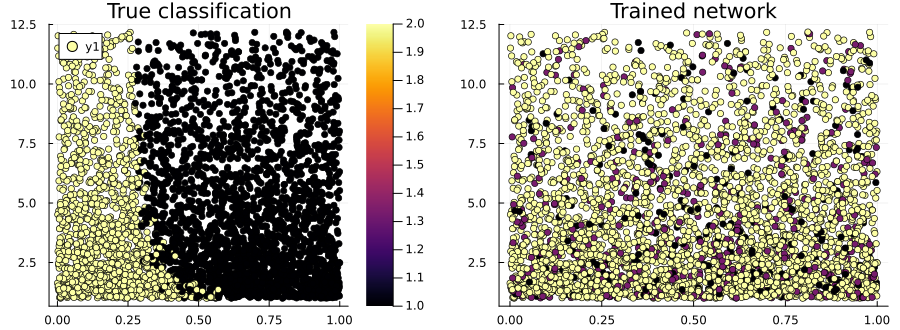

In [ ]:
p_true = scatter(x_test[3,:], x_test[4,:], zcolor=y_test, title="True classification", legend=true,
markersize=3.5, palette = cgrad(:plasma))
p_done = scatter(x_test[3,:], x_test[4,:], zcolor=predicted_labels, title="Trained network", legend=false,
markersize=3.5, palette = cgrad(:plasma))

plot(p_true, p_done, layout=(1,2), size=(900,330))

In [ ]:
accuracy = mean(predicted_labels .== y_test)

0.0945